# Origin-destination matrix estimation: Gravity model

We use the scikit-mobility models to estimate an O-D matrix using the gravity model (based on the generalized model from [Barbosa et al. 2018](https://www.sciencedirect.com/science/article/abs/pii/S037015731830022X)):

$$
T_{ij} = K \frac{m_i^\alpha m_j^\beta}{f(d_{ij})}
$$

where:
- $T_{ij}$: number of trips from zone $i$ to zone $j$,
- $m_i$ and $m_j$  and relate to the number of trips leaving location $i$ / the ones attracted by location $j$,
- $d_{ij}$ is the distance between zones $i$ and $j$,
- $f(d_{ij})$ is the "deterrence function" that decreases the number of trips as the distance increases,
- $K$: constant of proportionality
- $\alpha$, $\beta$: parameters to be estimated

In our case, $f$ is chosen as a power-law function (exponent is estimated), and $\alpha$ as 1.



In [1]:
import skmob
from skmob.utils import utils, constants
import pandas as pd
import geopandas as gpd
import numpy as np
from skmob.models import gravity
from skmob.models.gravity import Gravity

#import map_functions
import computing_functions
import matplotlib.pyplot as plt
import networkx as nx

## 16 major cities: ODM estimation

Initializations:

In [2]:
from shapely.geometry import Point

ksh_stats = pd.read_csv("data/sources/KSH/KSHSettlList_settlID_settlname_pop_lat_lon.csv")
ksh_flows = pd.read_csv("data/sources/KSH/KSHCommuting_c1ID_c1name_c2ID_c2name_comm_school_work_UNDIR.csv")
ksh_flows_dir = pd.read_csv("data/sources/KSH/KSHCommuting_c1ID_c1name_c2ID_c2name_comm_school_work_DIR.csv")
gdf_hungary = gpd.read_file("data/sources/Hungary_2022_static_road_data.geojson")
#crs = gdf_hungary.crs
crs = "EPSG:4326"
cities = ['Budapest', 'Kecskemét', 'Szeged', 'Szolnok', 'Debrecen', 'Nyíregyháza', 'Miskolc', 'Dunaújváros', 'Szekszárd', 'Pécs', 'Székesfehérvár', 'Siófok', 'Győr', 'Sopron', 'Szombathely', 'Veszprém']
countries = ['Ausztria', 'Szlovákia', 'Ukrajna', 'Románia', 'Szerbia', 'Horvátország', 'Szlovénia']

Let's replace the õ and û characters to the Hungarian ö and ü characters, and store the id-place mapping in dicts.

In [3]:
def replace_letters(s):
    return s.replace("õ", "ő").replace("Õ", "Ő").replace("û", "ű").replace("Û", "Ű")
#non_english_letters = r'[^a-zA-Z]'; non_hungarian_letters = r'[^a-zA-ZáéíóöőúüűÁÉÍÓÖŐÚÜŰ]'
#non_hungarian = ksh_stats['Settlement_Name'].str.contains(non_hungarian_str, regex=True)
ksh_stats['Settlement_Name'] = ksh_stats['Settlement_Name'].apply(replace_letters)
ksh_flows['origName'] = ksh_flows['origName'].apply(replace_letters)
ksh_flows['destName'] = ksh_flows['destName'].apply(replace_letters)
ksh_flows_dir['origName'] = ksh_flows_dir['origName'].apply(replace_letters)
ksh_flows_dir['destName'] = ksh_flows_dir['destName'].apply(replace_letters)

place_id_dict = {}
for key, value in zip(ksh_flows_dir['origName'], ksh_flows_dir['origID']):
    if key in place_id_dict.keys():
        if place_id_dict[key] != value:
            print(key), print(value), print(place_id_dict[key])
    else:
        place_id_dict[key] = value
place_id_dict['Budapest'] = 13578

for i, row in ksh_flows.iterrows():
    if row['origName'] in place_id_dict.keys():
        ksh_flows.at[i, 'origID'] = place_id_dict[row['origName']]
    elif "Budapest" == (row['origName']):
        ksh_stats.at[i, 'origID'] = 13578
    elif row['origName'] not in countries:
        print(f"Problem with origName: {row['origName']}")
        print(row)

    if row['destName'] in place_id_dict.keys():
        ksh_flows.at[i, 'destID'] = place_id_dict[row['destName']]
    elif "Budapest" in (row['destName']):
        ksh_flows.at[i, 'destID'] = 13578
    elif row['destName'] not in countries:
        print(f"Problem with destName: {row['destName']}")
        print(row)

id_place_dict = { v:k for k, v in place_id_dict.items()}

ksh_flows.to_csv("data/sources/KSH/Commuting_undirected_corrected.csv", index=False)

Mátyus
20677
20668
Tibolddaróc
30456
30447


Two mistakes in the directed commuting dataset, these do not affect us. The undirected commuting dataset has swapped IDs for some cases, those are corrected.

Now let's create the O-D flow values and tessellation.

In [4]:
ksh_flows['origName'] = ksh_flows['origName'].apply(lambda x: 'Budapest' if 'Budapest' in x else x)
ksh_flows['destName'] = ksh_flows['destName'].apply(lambda x: 'Budapest' if 'Budapest' in x else x)

ksh_flows.loc[ksh_flows['origName'] == 'Budapest', 'origID'] = 13578
ksh_flows.loc[ksh_flows['destName'] == 'Budapest', 'destID'] = 13578

#Combine cases where the origID and destID are switched
ksh_flows['orig_dest'] = list(zip(ksh_flows['origID'], ksh_flows['destID']))
ksh_flows['orig_dest'] = ksh_flows['orig_dest'].apply(lambda x: tuple(sorted(x)))
ksh_flows_temp = ksh_flows.groupby(['orig_dest'])[['CommutersAll', 'CommutersSchool', 'CommutersWork']].sum().reset_index()
ksh_flows_temp[['origID', 'destID']] = pd.DataFrame(ksh_flows_temp['orig_dest'].tolist(), index=(ksh_flows_temp.index))
ksh_flows_temp = ksh_flows_temp.drop(columns=['orig_dest'])
ksh_flows = ksh_flows_temp.copy()
ksh_flows['origName'] = ksh_flows['origID'].apply(lambda x: id_place_dict[x])
ksh_flows['destName'] = ksh_flows['destID'].apply(lambda x: id_place_dict[x])
#Sum the last three columns for each pair of origID and destID
ksh_flows_combined = ksh_flows.groupby(['origID', 'origName', 'destID', 'destName'])[['CommutersAll', 'CommutersSchool', 'CommutersWork']].sum().reset_index()

geometry = [Point(xy) for xy in zip(ksh_stats['longitude'], ksh_stats['latitude'])]
gdf_ksh = (gpd.GeoDataFrame(ksh_stats, crs="EPSG:4326", geometry=geometry)).to_crs(crs)

gdf_16 = gdf_ksh[gdf_ksh['Settlement_Name'].isin(cities)]
odf_16 = ksh_flows_combined[(ksh_flows_combined['origName'].isin(cities)) & (ksh_flows_combined['destName'].isin(cities))]
odf_16 = odf_16.rename(columns={'origID': 'origin', 'destID': 'destination', 'CommutersAll': 'flow'})
odf_16 = odf_16.drop(columns=['CommutersSchool', 'CommutersWork', 'origName', 'destName'])
odf_16 = odf_16[[odf_16.columns[-1]]+list(odf_16.columns[:-1])] #Swap the columns
odf_16 = pd.concat([odf_16, pd.DataFrame([{'flow':0,'origin': place_id_dict['Szekszárd'], 'destination':place_id_dict['Nyíregyháza']}])], ignore_index=True)
#The od matrix is symmetric, so we can add the same flows in the opposite direction
odf_16 = (pd.concat([odf_16, odf_16.rename(columns={'origin': 'destination', 'destination': 'origin'})], ignore_index=True))
odf_16 = odf_16.drop_duplicates()
odf_16 = odf_16.reset_index(drop=True)

gdf_bp = gdf_ksh[gdf_ksh['Settlement_Name'].str.contains("Budapest")].copy()
gdf_bp.loc[:, 'Settlement_Name'] = 'Budapest'
bp_aggregations = {col: 'first' for col in gdf_bp.columns} #Select the first value of each column
bp_aggregations['Population'] = 'sum' #except for 'Population', which is summed
#Groupby,aggregate
gdf_bp = gdf_bp.groupby('Settlement_Name', as_index=False).agg(bp_aggregations)

gdf_16 = pd.concat([gdf_bp,gdf_16 ], ignore_index=True)

tessellation_16 = gdf_16.copy().drop(columns=[ 'latitude', 'longitude','Settlement_Name']).rename(columns={'Settlement_ID': 'tile_ID', 'Population': 'population'})
tessellation_16 = gpd.GeoDataFrame(tessellation_16, geometry='geometry')
tessellation_16.crs = crs
tessellation_16.loc[0, 'tile_ID'] = 13578

tessellation_16.to_file("data/sources/KSH/tessellation_16_cities.geojson", driver='GeoJSON', index=False)
odf_16.to_csv("data/sources/KSH/flows_16_cities.csv", index=False)

In [5]:
tessellation_16

,tile_ID,population,geometry
0,13578,1740041,POINT (19.29790 47.48350)
1,3009,79348,POINT (16.62160 47.23090)
2,3115,48010,POINT (18.93290 46.96740)
3,8518,61390,POINT (16.59050 47.68500)
4,11767,64024,POINT (17.91150 47.09330)
5,14827,101722,POINT (18.41030 47.18990)
6,15130,207594,POINT (21.63330 47.53330)
7,17206,117658,POINT (21.71670 47.95540)
8,17631,24375,POINT (18.05800 46.90410)
9,19415,156801,POINT (18.23330 46.08330)


We do not need intra-city flows, so we drop these cases:

In [6]:
odf_16_inter = odf_16[odf_16['origin']!=odf_16['destination']]
odf_16_inter.to_csv("data/sources/KSH/flows_inter_16_cities.csv", index=False)

Using these, we can create the FlowDataFrame:

In [7]:
#load real flows into a FlowDataFrame
fdf = skmob.FlowDataFrame.from_file("data/sources/KSH/flows_inter_16_cities.csv",
                                        tessellation=tessellation_16,
                                        tile_id='tile_ID',
                                        sep=",")
fdf['origin'] = fdf['origin'].astype('int64')
fdf['destination'] = fdf['destination'].astype('int64')
fdf.tessellation[constants.TILE_ID] = fdf.tessellation[constants.TILE_ID].astype('int64')

The FlowDataFrame aside from having O-D flow values, also stores the tessellation info in `fdf.tessellation`.

Now we compute the total outflows for each zone, for the $m_i$ term in the gravity model.

In [8]:
# compute the total outflows from each location of the tessellation (excluding self loops) #fdf['origin'] != fdf['destination']
tot_outflows = fdf.groupby(by='origin', axis=0)[['flow']].sum().fillna(0)
tessellation = tessellation_16.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': constants.TOT_OUTFLOW})

In [9]:
tessellation

,tile_ID,population,geometry,tot_outflow
0,13578,1740041,POINT (19.29790 47.48350),33230
1,3009,79348,POINT (16.62160 47.23090),1898
2,3115,48010,POINT (18.93290 46.96740),3122
3,8518,61390,POINT (16.59050 47.68500),2100
4,11767,64024,POINT (17.91150 47.09330),3385
5,14827,101722,POINT (18.41030 47.18990),8421
6,15130,207594,POINT (21.63330 47.53330),5948
7,17206,117658,POINT (21.71670 47.95540),4338
8,17631,24375,POINT (18.05800 46.90410),1759
9,19415,156801,POINT (18.23330 46.08330),3694


Let's try a simple random gravity model:

(singly constrained: the amount of trips leaving a zone is fixed, only the destination can change)

In [10]:
# instantiate a singly constrained Gravity model
gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)
np.random.seed(0)
synth_fdf = gravity_singly.generate(tessellation,
                                   tile_id_column='tile_ID',
                                   tot_outflows_column='tot_outflow',
                                   relevance_column= 'population',
                                   out_format='flows')

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


100%|██████████| 16/16 [00:00<?, ?it/s]
c:\Users\hanic\.pyenv\pyenv-win\versions\3.9.1\lib\site-packages\skmob\models\gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


We can also fit the model on the data:

In [11]:
# fit the parameters of the Gravity model from real fluxes
gravity_singly_fitted = Gravity(gravity_type='singly constrained')
print(gravity_singly_fitted)
gravity_singly_fitted.fit(fdf, relevance_column='population')
print(gravity_singly_fitted)


Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")
Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-1.8816669593660775], origin_exp=1.0, destination_exp=1.0284599048495415, gravity_type="singly constrained")


*Update 05.12*: We see the deterrence function's exponent is set to be ~-1.882, and the destination exponent is ~1.028 (previously -1.791 and 0.966). 

In [12]:
np.random.seed(0)
synth_fdf_fitted = gravity_singly_fitted.generate(tessellation,
                                                        tile_id_column='tile_ID',
                                                        tot_outflows_column='tot_outflow',
                                                        relevance_column= 'population',
                                                        out_format='flows')

100%|██████████| 16/16 [00:00<?, ?it/s]
c:\Users\hanic\.pyenv\pyenv-win\versions\3.9.1\lib\site-packages\skmob\models\gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


Let's build the O-D matrix for both cases:

<details><summary>Previous code</summary>

```python

places_sorted = [id_place_dict[int(id)] for id in fdf['destination'].unique()]
odm_2d = np.zeros((len(places_sorted), len(places_sorted)))
odm_2d_fitted = np.zeros((len(places_sorted), len(places_sorted)))

for i, row in synth_fdf.iterrows():
    o = id_place_dict[int(row['origin'])]; d = id_place_dict[int(row['destination'])]; f = row['flow']
    odm_2d[places_sorted.index(o), places_sorted.index(d)] = f

for i, row in synth_fdf_fitted.iterrows():
    o = id_place_dict[int(row['origin'])]; d = id_place_dict[int(row['destination'])]; f = row['flow']
    odm_2d_fitted[places_sorted.index(o), places_sorted.index(d)] = f

```

</details>

In [13]:
synth_fdf['origin'] = synth_fdf['origin'].astype('int64')
synth_fdf['destination'] = synth_fdf['destination'].astype('int64')

synth_fdf_fitted['origin'] = synth_fdf_fitted['origin'].astype('int64')
synth_fdf_fitted['destination'] = synth_fdf_fitted['destination'].astype('int64')

In [14]:
odm_2d = computing_functions.odm_ids_df_to_odm_2d_symmetric(synth_fdf, id_place_dict, cities)
odm_2d_fitted = computing_functions.odm_ids_df_to_odm_2d_symmetric(synth_fdf_fitted, id_place_dict, cities)

Visualizing the results:

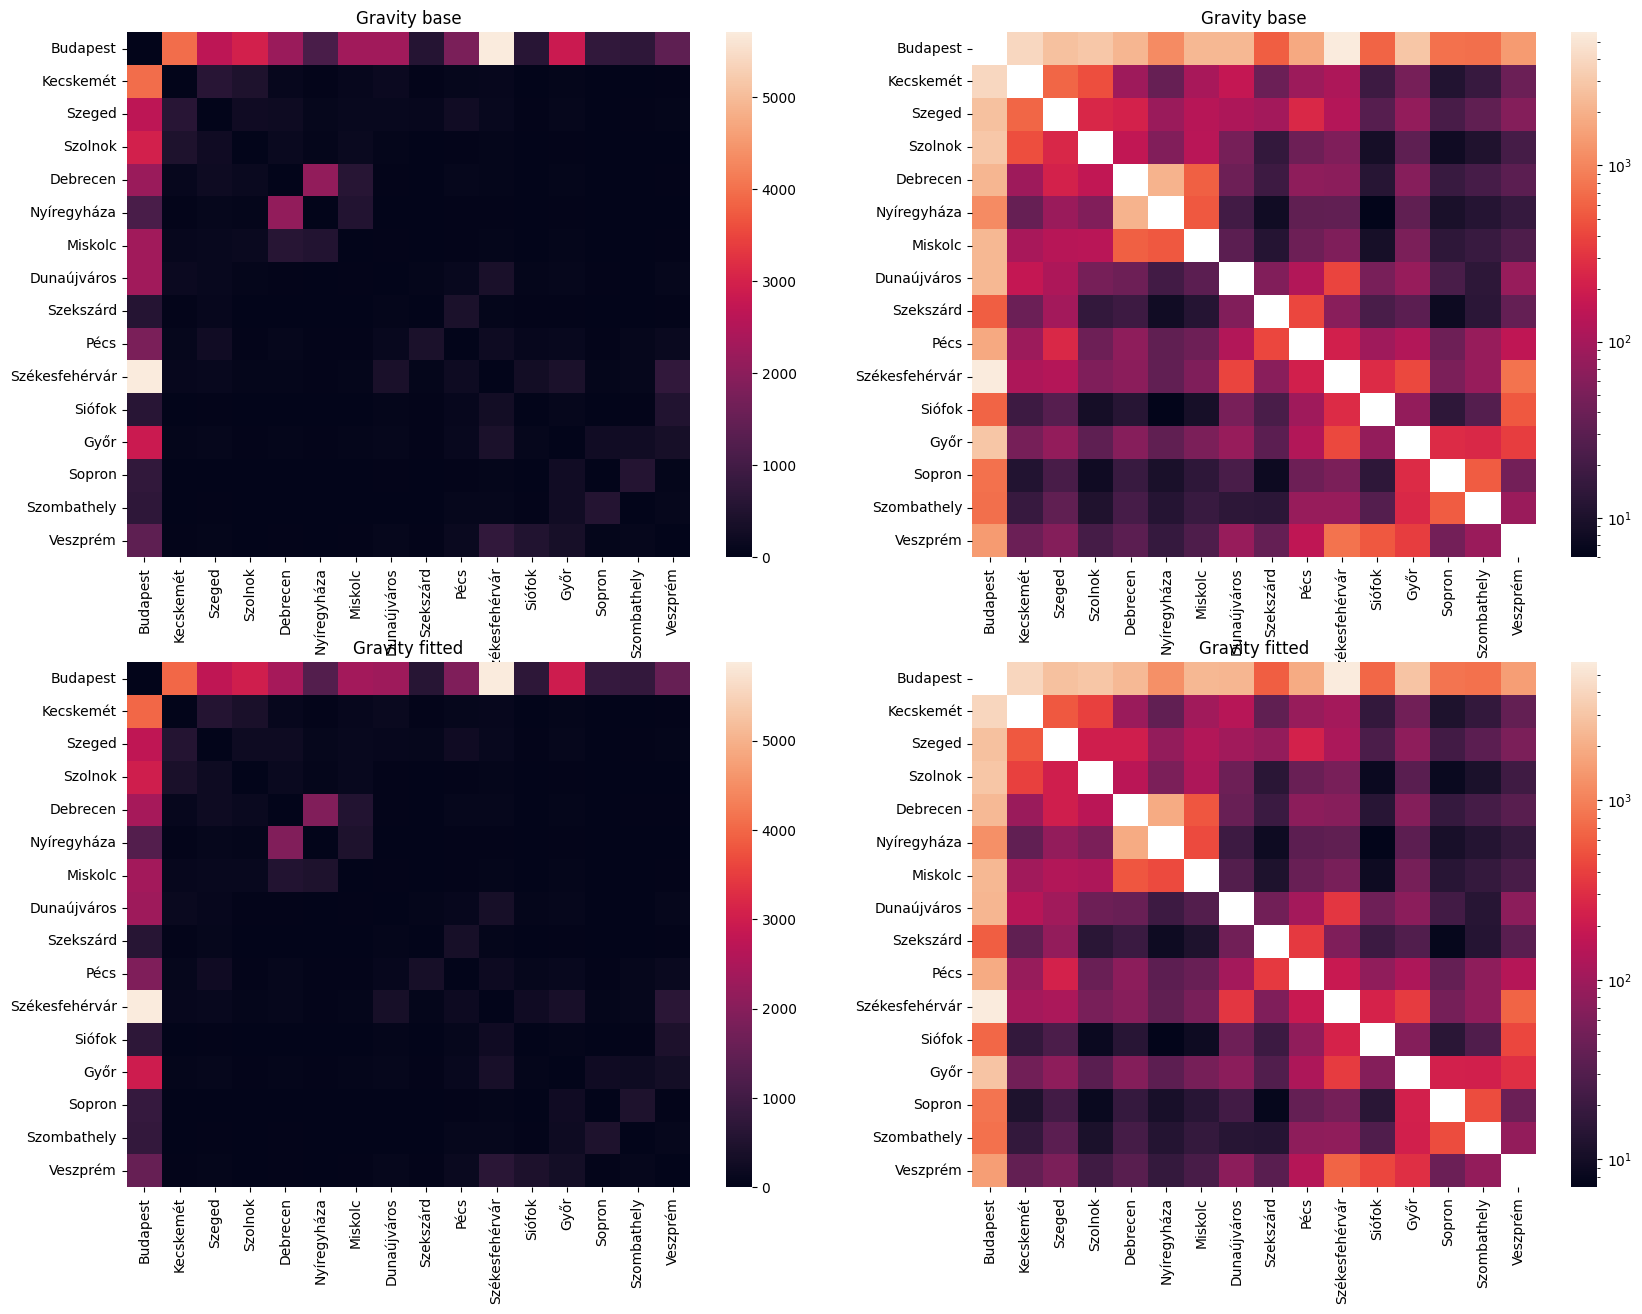

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_2d, cities, ax = ax[0,0], title="Gravity base")
computing_functions.plot_odm_axis(odm_2d, cities, ax = ax[0,1], title="Gravity base", log_scale=True)
computing_functions.plot_odm_axis(odm_2d_fitted, cities, ax = ax[1,0], title="Gravity fitted")
computing_functions.plot_odm_axis(odm_2d_fitted, cities, ax = ax[1,1], title="Gravity fitted", log_scale=True)


The difference between the fitted and not fitted models is not much, but brings down a bit of closeness bias:

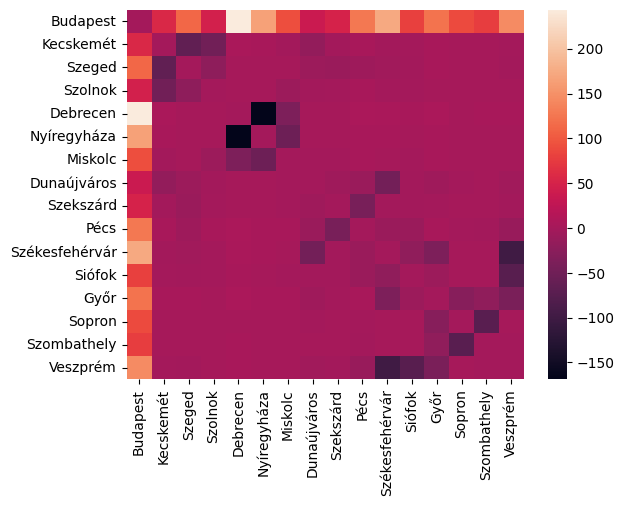

In [16]:
computing_functions.plot_odm(odm_2d_fitted-odm_2d, cities)

If we look at traffic data, we see that this model is not very fantastic in the end.

In [17]:
synth_fdf['origin'] = synth_fdf['origin'].apply(lambda x: id_place_dict[int(x)])
synth_fdf['destination'] = synth_fdf['destination'].apply(lambda x: id_place_dict[int(x)])
synth_fdf_fitted['origin'] = synth_fdf_fitted['origin'].apply(lambda x: id_place_dict[int(x)])
synth_fdf_fitted['destination'] = synth_fdf_fitted['destination'].apply(lambda x: id_place_dict[int(x)])

In [18]:
synth_fdf.to_csv("computing/odm/ODM_16_cities_gravity_unfitted.csv", index=False)
synth_fdf_fitted.to_csv("computing/odm/ODM_16_cities_gravity_fitted.csv", index=False)